# Alert Investigation - Windows Process Alerts
&lt;details&gt;
    <summary> <u>Details...</u></summary>
**Notebook Version:** 1.1<br>

**Data Sources Used**:<br>
- Log Analytics/Azure Sentinel
    - SecurityAlert 
    - SecurityEvent
<br>
- Threat Intelligence Providers (Optional)
    - OTX (https://otx.alienvault.com/)
    - VirusTotal (https://www.virustotal.com/)
    - XForce (https://www.ibm.com/security/xforce)
&lt;/details&gt;

This notebook is intended for triage and investigation of security alerts related to process execution. It is specifically targeted at alerts triggered by suspicious process activity on Windows hosts. 

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Hunting-Hypothesis" data-toc-modified-id="Hunting-Hypothesis-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Hunting Hypothesis</a></span></li><li><span><a href="#Notebook-Initialization" data-toc-modified-id="Notebook-Initialization-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Notebook Initialization</a></span><ul class="toc-item"><li><span><a href="#Get-WorkspaceId-and-Authenticate-to-Log-Analytics" data-toc-modified-id="Get-WorkspaceId-and-Authenticate-to-Log-Analytics-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Get WorkspaceId and Authenticate to Log Analytics</a></span></li></ul></li><li><span><a href="#Get-List-of-Alerts" data-toc-modified-id="Get-List-of-Alerts-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Get List of Alerts</a></span></li><li><span><a href="#Choose-Alert-to-Investigate" data-toc-modified-id="Choose-Alert-to-Investigate-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Choose Alert to Investigate</a></span></li><li><span><a href="#Extract-properties-and-entities-from-Alert" data-toc-modified-id="Extract-properties-and-entities-from-Alert-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Extract properties and entities from Alert</a></span></li><li><span><a href="#Entity-Graph" data-toc-modified-id="Entity-Graph-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Entity Graph</a></span></li><li><span><a href="#Related-Alerts" data-toc-modified-id="Related-Alerts-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Related Alerts</a></span><ul class="toc-item"><li><span><a href="#Show-these-related-alerts-on-a-graph" data-toc-modified-id="Show-these-related-alerts-on-a-graph-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Show these related alerts on a graph</a></span></li><li><span><a href="#Browse-List-of-Related-Alerts" data-toc-modified-id="Browse-List-of-Related-Alerts-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Browse List of Related Alerts</a></span></li></ul></li><li><span><a href="#Get-Process-Tree" data-toc-modified-id="Get-Process-Tree-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Get Process Tree</a></span><ul class="toc-item"><li><span><a href="#Process-Time-Line" data-toc-modified-id="Process-Time-Line-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Process Time Line</a></span></li></ul></li><li><span><a href="#Other-Processes-on-Host---Clustering" data-toc-modified-id="Other-Processes-on-Host---Clustering-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Other Processes on Host - Clustering</a></span><ul class="toc-item"><li><span><a href="#Clustered-Processes" data-toc-modified-id="Clustered-Processes-9.1"><span class="toc-item-num">9.1&nbsp;&nbsp;</span>Clustered Processes</a></span></li><li><span><a href="#Variability-in-Command-Lines-and-Process-Names" data-toc-modified-id="Variability-in-Command-Lines-and-Process-Names-9.2"><span class="toc-item-num">9.2&nbsp;&nbsp;</span>Variability in Command Lines and Process Names</a></span></li><li><span><a href="#Time-Line-of--clustered-processes-data-vs.-original-data" data-toc-modified-id="Time-Line-of--clustered-processes-data-vs.-original-data-9.3"><span class="toc-item-num">9.3&nbsp;&nbsp;</span>Time Line of  clustered processes data vs. original data</a></span></li></ul></li><li><span><a href="#Base64-Decode-and-Check-for-IOCs" data-toc-modified-id="Base64-Decode-and-Check-for-IOCs-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Base64 Decode and Check for IOCs</a></span><ul class="toc-item"><li><span><a href="#IoCs-in-the-entire-data-set" data-toc-modified-id="IoCs-in-the-entire-data-set-10.1"><span class="toc-item-num">10.1&nbsp;&nbsp;</span>IoCs in the entire data set</a></span></li><li><span><a href="#If-any-Base64-encoded-strings,-decode-and-search-for-IoCs-in-the-results." data-toc-modified-id="If-any-Base64-encoded-strings,-decode-and-search-for-IoCs-in-the-results.-10.2"><span class="toc-item-num">10.2&nbsp;&nbsp;</span>If any Base64 encoded strings, decode and search for IoCs in the results.</a></span></li></ul></li><li><span><a href="#Threat-Intelligence-Lookup" data-toc-modified-id="Threat-Intelligence-Lookup-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Threat Intelligence Lookup</a></span></li><li><span><a href="#Alert-command-line---Occurrence-on-other-hosts-in-workspace" data-toc-modified-id="Alert-command-line---Occurrence-on-other-hosts-in-workspace-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Alert command line - Occurrence on other hosts in workspace</a></span></li><li><span><a href="#Host-Logons" data-toc-modified-id="Host-Logons-13"><span class="toc-item-num">13&nbsp;&nbsp;</span>Host Logons</a></span></li><li><span><a href="#Alert-Logon-Account" data-toc-modified-id="Alert-Logon-Account-14"><span class="toc-item-num">14&nbsp;&nbsp;</span>Alert Logon Account</a></span><ul class="toc-item"><li><span><a href="#All-Host-Logons" data-toc-modified-id="All-Host-Logons-14.1"><span class="toc-item-num">14.1&nbsp;&nbsp;</span>All Host Logons</a></span></li><li><span><a href="#Comparing-All-Logons-with-Clustered-results-relative-to-Alert-time-line" data-toc-modified-id="Comparing-All-Logons-with-Clustered-results-relative-to-Alert-time-line-14.2"><span class="toc-item-num">14.2&nbsp;&nbsp;</span>Comparing All Logons with Clustered results relative to Alert time line</a></span></li><li><span><a href="#View-Process-Session-and-Logon-Events-in-Timelines" data-toc-modified-id="View-Process-Session-and-Logon-Events-in-Timelines-14.3"><span class="toc-item-num">14.3&nbsp;&nbsp;</span>View Process Session and Logon Events in Timelines</a></span></li></ul></li><li><span><a href="#Failed-Logons" data-toc-modified-id="Failed-Logons-15"><span class="toc-item-num">15&nbsp;&nbsp;</span>Failed Logons</a></span></li><li><span><a href="#Appendices" data-toc-modified-id="Appendices-16"><span class="toc-item-num">16&nbsp;&nbsp;</span>Appendices</a></span><ul class="toc-item"><li><span><a href="#Available-DataFrames" data-toc-modified-id="Available-DataFrames-16.1"><span class="toc-item-num">16.1&nbsp;&nbsp;</span>Available DataFrames</a></span></li><li><span><a href="#Saving-Data-to-CSV" data-toc-modified-id="Saving-Data-to-CSV-16.2"><span class="toc-item-num">16.2&nbsp;&nbsp;</span>Saving Data to CSV</a></span></li><li><span><a href="#Saving-Data-to-Excel" data-toc-modified-id="Saving-Data-to-Excel-16.3"><span class="toc-item-num">16.3&nbsp;&nbsp;</span>Saving Data to Excel</a></span></li></ul></li><li><span><a href="#Setup-Cell" data-toc-modified-id="Setup-Cell-17"><span class="toc-item-num">17&nbsp;&nbsp;</span>Setup Cell</a></span><ul class="toc-item"><li><span><a href="#msticpyconfig.yaml-configuration-File" data-toc-modified-id="msticpyconfig.yaml-configuration-File-17.1"><span class="toc-item-num">17.1&nbsp;&nbsp;</span><code>msticpyconfig.yaml</code> configuration File</a></span></li></ul></li></ul></div>

<a></a>[Contents](#toc)
## Hunting Hypothesis
Our broad initial hunting hypothesis is that a we have received an alert/indicators involving windows process name which is suspected to be malicious, we will need to hunt from a range of different positions to validate or disprove this hypothesis.

Before you start hunting please run the cells in <a>Setup</a> at the bottom of this Notebook.

## Notebook Initialization
&lt;details&gt;
    <summary> <u>Details...</u></summary>
        If this is your first time running this Notebook please run the cells in in the <a>Setup</a> section before proceeding  to ensure you have the required packages installed correctly. Similarly if you see any import failures (```ImportError```) in the notebook, please make sure that you have run the [Setup](#setup) section first.
    &lt;/details&gt;

In [1]:
# Imports
import sys
import warnings
from msticpy.nbtools.utility import check_py_version

MIN_REQ_PYTHON = (3, 6)
check_py_version(MIN_REQ_PYTHON)

import numpy as np
from IPython import get_ipython
from IPython.display import display, HTML, Markdown
import ipywidgets as widgets

import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
sns.set()


import pandas as pd
#setting pandas display options for dataframe
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_colwidth", 100)

# msticpy imports
from msticpy.data import QueryProvider
from msticpy.nbtools.entityschema import IpAddress, GeoLocation
from msticpy.nbtools import *
from msticpy.sectools import *
from msticpy.nbtools.foliummap import FoliumMap
from msticpy.nbtools.utility import md, md_warn, check_and_install_missing_packages
from msticpy.nbtools.wsconfig import WorkspaceConfig
from msticpy.nbtools.query_defns import DataFamily

WIDGET_DEFAULTS = {
    "layout": widgets.Layout(width="95%"),
    "style": {"description_width": "initial"},
}

# Some of our dependencies (networkx) still use deprecated Matplotlib
# APIs - we can't do anything about it so suppress them from view
from matplotlib import MatplotlibDeprecationWarning
warnings.simplefilter("ignore", category=MatplotlibDeprecationWarning)



<a></a>[Contents](#toc)
### Get WorkspaceId and Authenticate to Log Analytics 
&lt;details&gt;
    <summary> <u>Details...</u></summary>
If you are using user/device authentication, run the following cell. 
- Click the 'Copy code to clipboard and authenticate' button.
- This will pop up an Azure Active Directory authentication dialog (in a new tab or browser window). The device code will have been copied to the clipboard. 
- Select the text box and paste (Ctrl-V/Cmd-V) the copied value. 
- You should then be redirected to a user authentication page where you should authenticate with a user account that has permission to query your Log Analytics workspace.

Use the following syntax if you are authenticating using an Azure Active Directory AppId and Secret:
```
%kql loganalytics://tenant(aad_tenant).workspace(WORKSPACE_ID).clientid(client_id).clientsecret(client_secret)
```
instead of
```
%kql loganalytics://code().workspace(WORKSPACE_ID)
```

Note: you may occasionally see a JavaScript error displayed at the end of the authentication - you can safely ignore this.<br>
On successful authentication you should see a ```popup schema``` button.
To find your Workspace Id go to [Log Analytics](https://ms.portal.azure.com/#blade/HubsExtension/Resources/resourceType/Microsoft.OperationalInsights%2Fworkspaces). Look at the workspace properties to find the ID.
&lt;/details&gt;

In [5]:
# Authentication
ws_config = WorkspaceConfig(workspace="CyberSecurityDemo")
qry_prov = QueryProvider(data_environment="LogAnalytics")
qry_prov.connect(connection_str=ws_config.code_connect_str)
table_index = qry_prov.schema_tables

## Get List of Alerts

We are using an alert as the starting point for this investigation, specify a time range to search for alerts. Once this is set run the following cell to retrieve any alerts in that time window.
You can change the time range and re-run the queries until you find the alerts that you want to investigate.

In [6]:
alert_q_times = nbwidgets.QueryTime(units='hour',
                                      max_before=30, max_after=1, before=3)
alert_q_times.display()

HTML(value='<h4>Set query time boundaries</h4>')

In [11]:
alert_list = qry_prov.SecurityAlert.list_alerts(
    alert_q_times)
alert_counts = qry_prov.SecurityAlert.list_alerts_counts(
    alert_q_times)

if isinstance(alert_list, pd.DataFrame) and not alert_list.empty:
    print(len(alert_counts), ' distinct alert types')
    print(len(alert_list), ' distinct alerts')

# Display alerts on timeline to aid in visual grouping
    nbdisplay.display_timeline(
        data=alert_list, source_columns=["AlertName", 'CompromisedEntity'], title="Alerts over time", height=300, color="red")
    display(alert_counts.head(10)) # remove '.head(10)'' to see the full list grouped by AlertName
else:
    display(Markdown('No alerts found.'))

24  distinct alert types
119  distinct alerts


Loading BokehJS ...

,AlertName,alertCount,firstAlert,lastAlert
0,DDoS Mitigation in Progress,29,2019-12-30 15:47:39,2019-12-30 21:17:31
1,Anomaly with data size transferred to public internet,25,2019-12-29 21:17:12,2019-12-30 21:17:20
2,DDoS Attack mitigated for Public IP,10,2019-12-30 16:23:39,2019-12-30 19:21:40
3,DDoS Attack detected for Public IP,10,2019-12-30 15:39:03,2019-12-30 20:53:11
4,Suspicious authentication activity,9,2019-12-29 20:33:06,2019-12-30 10:36:12
5,Traffic detected from IP addresses recommended for blocking,6,2019-12-30 08:18:05,2019-12-30 08:36:52
6,Users targeted by phish campaigns,6,2019-12-30 05:21:32,2019-12-30 05:21:32
7,Mass Resource Access by User (haven't accessed by his peers),4,2019-12-29 22:00:30,2019-12-30 13:00:31
8,Local Administrators group members were enumerated,4,2019-12-29 20:28:29,2019-12-30 20:35:03
9,MeganB - Mass download by a single user,2,2019-12-30 15:48:49,2019-12-30 15:51:48


## Choose Alert to Investigate
To focus the investigation select an alert from a list of retrieved alerts.

As you select an alert, the main properties will be shown below the list.

Use the filter box to narrow down your search to any substring in the AlertName.

In [12]:
get_alert = None
alert_select = nbwidgets.AlertSelector(alerts=alert_list, action=nbdisplay.display_alert)
alert_select.display()

## Extract properties and entities from Alert
In order to pivot to data related to the selected security alert we need to identify key data points in the selected alert. This section extracts the alert information and entities into a SecurityAlert object allowing us to query the properties more reliably. 

Properties in this object will be used to automatically provide parameters for queries and UI elements.
Subsequent queries will use properties like the host name and derived properties such as the OS family (Linux or Windows) to adapt the query. Query time selectors like the one above will also default to an origin time that matches the alert selected.

The alert view below shows all of the main properties of the alert plus the extended property dictionary (if any) and JSON representations of the Entity.

In [13]:
# Extract entities and properties into a SecurityAlert class
if alert_select is None or alert_select.selected_alert is None:
    raise ValueError("Please select an alert before executing remaining cells.")
else:
    security_alert = SecurityAlert(alert_select.selected_alert)
    
nbdisplay.display_alert(security_alert, show_entities=True)

,54
TenantId,ab86c959-1ba3-495c-a00d-ced30d8825d3
TimeGenerated,2019-12-30 15:56:46
AlertDisplayName,Local Administrators group members were enumerated
AlertName,Local Administrators group members were enumerated
Severity,Informational
Description,"Machine logs indicate a successful enumeration on group Builtin\Administrators.\r\nSpecifically, CONTOSO\AatpService remotely enumerated the members of the Builtin\Administrators group.\r\nThis activity could either be legitimate activity, or an indication that a machine in your organization has been compromised and used to reconnaissance AdminPC.Contoso.Azure."
ProviderName,Detection
VendorName,Microsoft
VendorOriginalId,e3d01cdb-131b-4cbf-9c31-15ce8d927640
SystemAlertId,2518246655787799999_e3d01cdb-131b-4cbf-9c31-15ce8d927640


{ 'AdditionalData': {},
  'AzureID': '/subscriptions/6b1ceacd-5731-4780-8f96-2078dd96fd96/resourcegroups/seccxp-ninja/providers/microsoft.compute/virtualmachines/adminpc',
  'DnsDomain': 'CONTOSO.AZURE',
  'HostName': 'ADMINPC',
  'NTDomain': 'CONTOSO',
  'NetBiosName': 'ADMINPC',
  'OMSAgentID': '88aac109-e3f1-4f4d-9951-9d2a13d79f43',
  'Type': 'host'}
{ 'AdditionalData': {},
  'Host': { 'AdditionalData': {},
            'AzureID': '/subscriptions/6b1ceacd-5731-4780-8f96-2078dd96fd96/resourcegroups/seccxp-ninja/providers/microsoft.compute/virtualmachines/adminpc',
            'DnsDomain': 'CONTOSO.AZURE',
            'HostName': 'ADMINPC',
            'NTDomain': 'CONTOSO',
            'NetBiosName': 'ADMINPC',
            'OMSAgentID': '88aac109-e3f1-4f4d-9951-9d2a13d79f43',
            'Type': 'host'},
  'IsDomainJoined': True,
  'LogonId': '0x81f2cdc9',
  'NTDomain': 'CONTOSO',
  'Name': 'AatpService',
  'Sid': 'S-1-5-21-2839646386-741382897-445212193-1107',
  'Type': 'account'}
{'

## Entity Graph
Depending on the type of alert there may be one or more entities attached as properties. Entities are key indicators that we can pivot on during our investigation, such as Host, Account, IpAddress, Process, etc. - essentially the 'nouns' of security investigation. 
Entities are often related to other entities - for example a process will usually have a related file entity (the process image) and an Account entity (the context in which the process was running). Endpoint alerts typically always have a host entity (which could be a physical or virtual machine). In order to more effectively understand the links between related entities we can plot them as a graph.

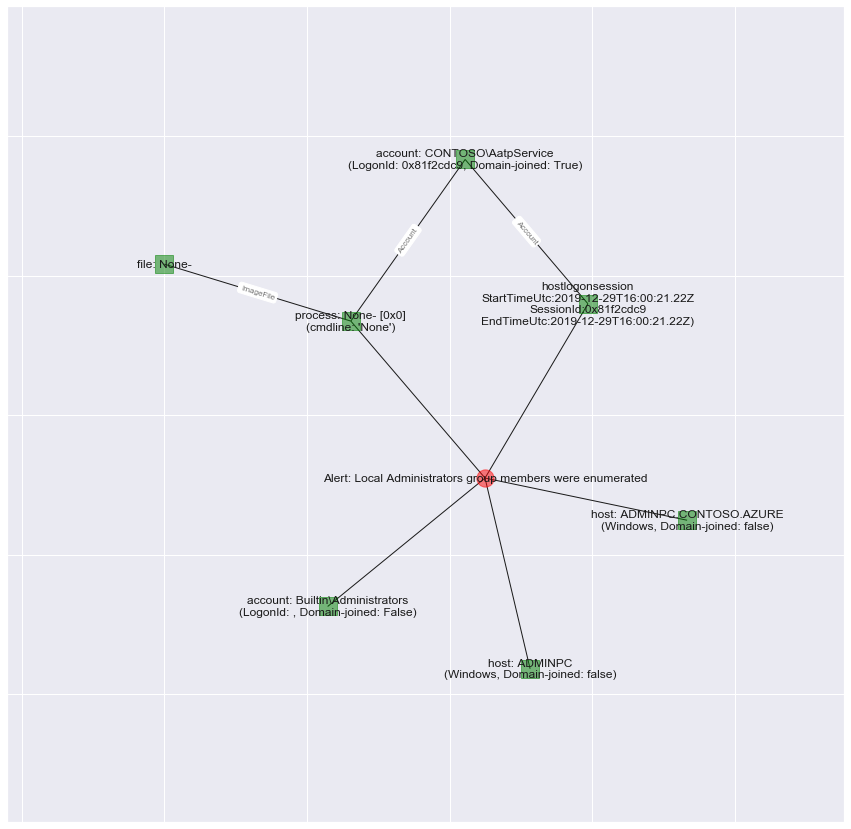

In [14]:
# Draw the graph using Networkx/Matplotlib
%matplotlib inline
alertentity_graph = security_alert_graph.create_alert_graph(security_alert)
nbdisplay.draw_alert_entity_graph(alertentity_graph, width=15)


## Related Alerts
For certain entities in the alert we can search for other alerts that have that entity in common. Currently this pivot supports alerts with the same Host, Account or Process. 

**Notes:**
- Some alert types do not include all of these entity types.
- The original alert will be included in the "Related Alerts" set if it occurs within the query time boundary set below.

In order to more effectively identify related alerts the query time boundaries can be adjusted to encompass a longer time frame.

In [15]:
# set the origin time to the time of our alert
query_times = nbwidgets.QueryTime(units='day', origin_time=security_alert.TimeGenerated, 
                            max_before=28, max_after=1, before=5)
query_times.display()

HTML(value='<h4>Set query time boundaries</h4>')

In [16]:
if not security_alert.primary_host:
    md_warn('Related alerts is not yet supported for alerts that are not host-based')
    related_alerts = None
else:
    hostname = security_alert.hostname
    if not hostname and "AzureID" in security_alert.primary_host:
        hostname = security_alert.primary_host.AzureID.split("/")[-1]
    related_alerts = qry_prov.SecurityAlert.list_related_alerts(query_times, security_alert, host_name=hostname)


    if related_alerts is not None and not related_alerts.empty:
        host_alert_items = related_alerts\
            .query('host_match == @True')[['AlertType', 'StartTimeUtc']]\
            .groupby('AlertType').StartTimeUtc.agg('count').to_dict()
        acct_alert_items = related_alerts\
            .query('acct_match == @True')[['AlertType', 'StartTimeUtc']]\
            .groupby('AlertType').StartTimeUtc.agg('count').to_dict()
        proc_alert_items = related_alerts\
            .query('proc_match == @True')[['AlertType', 'StartTimeUtc']]\
            .groupby('AlertType').StartTimeUtc.agg('count').to_dict()

        def print_related_alerts(alertDict, entityType, entityName):
            if len(alertDict) > 0:
                print('Found {} different alert types related to this {} (\'{}\')'
                      .format(len(alertDict), entityType, entityName))
                for (k,v) in alertDict.items():
                    print('    {}, Count of alerts: {}'.format(k, v))
            else:
                print('No alerts for {} entity \'{}\''.format(entityType, entityName))

        print_related_alerts(host_alert_items, 'host', security_alert.hostname)
        print_related_alerts(acct_alert_items, 'account', 
                             security_alert.primary_account.qualified_name 
                             if security_alert.primary_account
                             else None)
        print_related_alerts(proc_alert_items, 'process', 
                             security_alert.primary_process.ProcessFilePath 
                             if security_alert.primary_process
                             else None)
        nbdisplay.display_timeline(data=related_alerts, source_columns = ['AlertName'], title='Alerts', height=100)
    else:
        md('No related alerts found.', styles=["bold","green"])

Found 3 different alert types related to this host ('ADMINPC')
    Login_BF_ValidUserFailed, Count of alerts: 5
    SCUBA_ADMINISTRATORSREMOTEENUM, Count of alerts: 5
    ab86c959-1ba3-495c-a00d-ced30d8825d3_bbd83fe8-f66a-47e0-ab56-d334c1ed0b8f, Count of alerts: 6
No alerts for account entity 'CONTOSO\AatpService'
No alerts for process entity 'None-'


Loading BokehJS ...

### Show these related alerts on a graph
To see the how these alerts relate to our original alert, and how these new alerts relate to each other we can graph them.

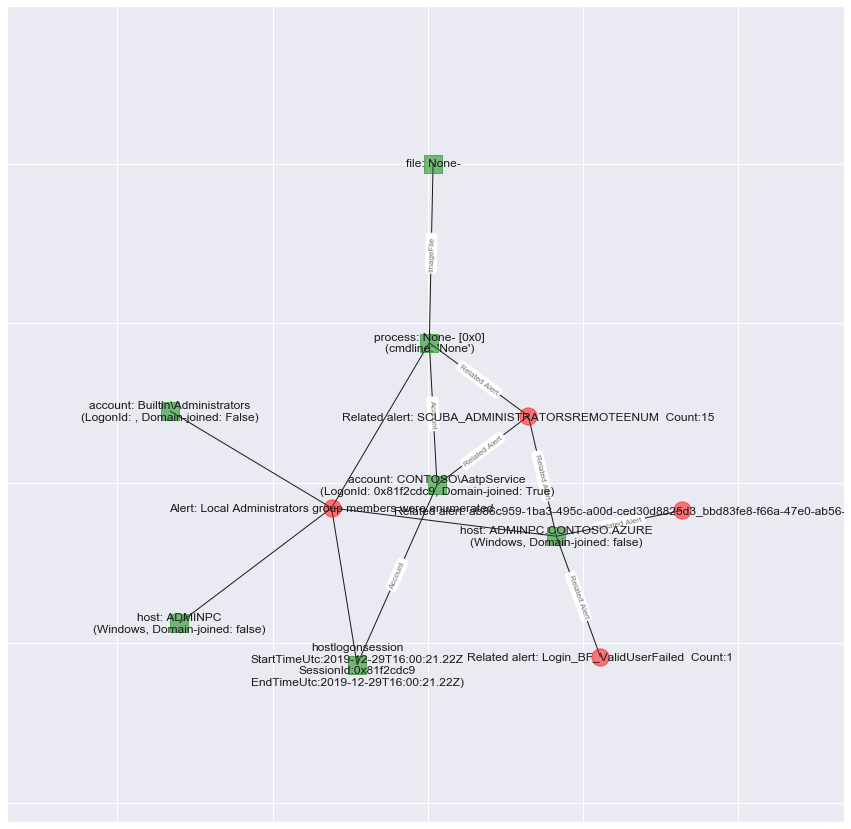

In [17]:
# Draw a graph of this (add to entity graph)
%matplotlib notebook
%matplotlib inline

if related_alerts is not None and not related_alerts.empty:
    rel_alert_graph = security_alert_graph.add_related_alerts(related_alerts=related_alerts,
                                             alertgraph=alertentity_graph)
    nbdisplay.draw_alert_entity_graph(rel_alert_graph, width=15)
else:
    md('No related alerts found.', styles=["bold","green"])

### Browse List of Related Alerts
Once we have understood how these alerts related to each other, we can view the details of each new, related alert.

In [18]:
def disp_full_alert(alert):
    global related_alert
    related_alert = SecurityAlert(alert)
    nbdisplay.display_alert(related_alert, show_entities=True)

if related_alerts is not None and not related_alerts.empty:
    related_alerts['CompromisedEntity'] = related_alerts['Computer']
    print('Selected alert is available as \'related_alert\' variable.')
    rel_alert_select = nbwidgets.AlertSelector(alerts=related_alerts, action=disp_full_alert)
    rel_alert_select.display()
else:
    md('No related alerts found.', styles=["bold","green"])

Selected alert is available as 'related_alert' variable.


## Get Process Tree
If the alert has a process entity this section tries to retrieve the entire process tree to which that process belongs.

Notes:
- The alert must have a process entity
- Only processes started within the query time boundary will be included
- Ancestor and descented processes are retrieved to two levels (i.e. the parent and grandparent of the alert process plus any child and grandchild processes).
- Sibling processes are the processes that share the same parent as the alert process
- This can be a long-running query, especially if a wide time window is used! Caveat Emptor!

The source (alert) process is shown in red.

What's shown for each process:
- Each process line is indented according to its position in the tree hierarchy
- Top line fields:
  - \[relationship to source process:lev# - where # is the hops away from the source process\]
  - Process creation date-time (UTC)
  - Process Image path
  - PID - Process Id
  - SubjSess - the session Id of the process spawning the new process
  - TargSess - the new session Id if the process is launched in another context/session. If 0/0x0 then the process is launched in the same session as its parent
- Second line fields:
  - Process command line
  - Account - name of the account context in which the process is running

In [19]:
# set the origin time to the time of our alert
query_times = nbwidgets.QueryTime(units='minute', origin_time=security_alert.origin_time)
query_times.display()

HTML(value='<h4>Set query time boundaries</h4>')

In [36]:
if security_alert.data_family != DataFamily.WindowsSecurity:
    raise ValueError('The remainder of this notebook currently only supports Windows. '
                     'Linux support is in development but not yet implemented.')

def extract_missing_pid(security_alert):
    for pid_ext_name in ['Process Id', 'Suspicious Process Id']:
        pid = security_alert.ExtendedProperties.get(pid_ext_name, None)
        if pid:
            return pid

def extract_missing_sess_id(security_alert):
    sess_id = security_alert.ExtendedProperties.get('Account Session Id', None)
    if sess_id:
        return sess_id
    for session in [e for e in security_alert.entities if
                    e['Type'] == 'host-logon-session' or e['Type'] == 'hostlogonsession']:
        return session['SessionId']
            
if (security_alert.primary_process):
    # Do some patching up if the process entity doesn't have a PID
    pid = security_alert.primary_process.ProcessId
    if not pid:
        pid = extract_missing_pid(security_alert)
        if pid:
            security_alert.primary_process.ProcessId = pid
        else:
            raise ValueError('Could not find the process Id for the alert process.')
    
    # Do the same if we can't find the account logon ID
    sess_id = security_alert.get_logon_id()
    if sess_id:
        sess_id = extract_missing_sess_id(security_alert)
        if sess_id and security_alert.primary_account:
            security_alert.primary_account.LogonId = sess_id
        else:
            raise ValueError('Could not find the session Id for the alert process.')
    
    # run the query
    process_tree = qry_prov.WindowsSecurity.get_process_tree(
        query_times,
        security_alert,
        process_id=pid,
        logon_session_id=sess_id,
        host_name=security_alert.primary_host.HostName,
        process_name=security_alert.primary_process.ImageFile.FullPath)

    if len(process_tree) > 0:
        # Print out the text view of the process tree
        nbdisplay.display_process_tree(process_tree)
    else:
        md('No processes were returned so cannot obtain a process tree Skip.', styles=["blue","bold"])
        md('Go to [Other Processes](#process_clustering) section later in the notebook to retrieve all processes', styles=["blue","bold"])
else:
    md('This alert has no process entity so cannot obtain a process tree.', styles=["blue","bold"])
    md('Skip to [Other Processes](#process_clustering) later in the notebook to retrieve all processes', styles=["bold","large"])
    process_tree = None

### Process Time Line
As well as seeing the processes involved in a tree we want to see the chronology of this process execution. This shows each process in the process tree on a time line view.
If a large number of processes are involved in this process tree it may take some time to display this time line graphic.

In [37]:
# Show timeline of events
if process_tree is not None and not process_tree.empty:
    nbdisplay.display_timeline(data=process_tree, alert=security_alert, 
                            title='Alert Process Session', height=250)

## Other Processes on Host - Clustering
Sometimes you don't have a source process from which to build our investigation. Other times it's just useful to see what other process activity is occurring on the host. This section retrieves all processes on the host within the time bounds
set in the query times widget.

If you want to view the raw details of this process data display the *processes_on_host* dataframe.

In order to more effectively analyze this process data we can cluster processes into distinct process clusters.
To do this we process the raw event list output to extract a few features that render strings (such as commandline)into numerical values. The default below uses the following features:
- commandLineTokensFull - this is a count of common delimiters in the commandline 
  (given by this regex r'[\s\-\\/\.,"\'|&amp;:;%$()]'). The aim of this is to capture the commandline structure while ignoring variations on what is essentially the same pattern (e.g. temporary path GUIDs, target IP or host names, etc.)
- pathScore - this sums the ordinal (character) value of each character in the path (so /bin/bash and /bin/bosh would have similar scores).
- isSystemSession - 1 if this is a root/system session, 0 if anything else.

Then we run a clustering algorithm (DBScan in this case) on the process list. The result groups similar (noisy) processes together and leaves unique process patterns as single-member clusters.

### Clustered Processes

Number of input events: 332
Number of clustered events: 19


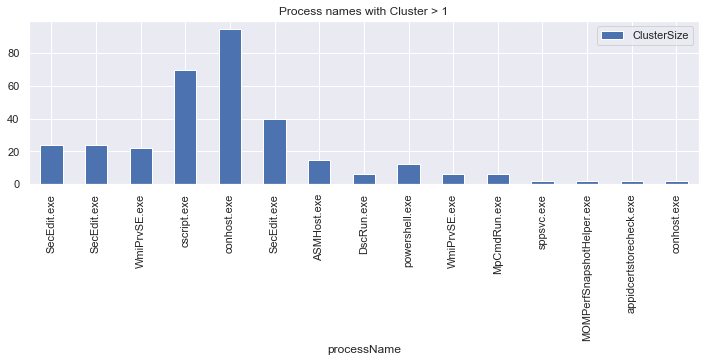

In [40]:
from msticpy.sectools.eventcluster import dbcluster_events, add_process_features

processes_on_host = None
if security_alert.primary_host:
    processes_on_host = qry_prov.WindowsSecurity.list_host_processes(
        query_times,
        security_alert,
        host_name=hostname
    )

    if processes_on_host is not None and not processes_on_host.empty:
        feature_procs = add_process_features(input_frame=processes_on_host,
                                             path_separator=security_alert.path_separator)

        # you might need to play around with the max_cluster_distance parameter.
        # decreasing this gives more clusters.
        (clus_events, dbcluster, x_data) = dbcluster_events(data=feature_procs,
                                                            cluster_columns=['commandlineTokensFull', 
                                                                             'pathScore', 
                                                                             'isSystemSession'],
                                                            max_cluster_distance=0.0001)
        print('Number of input events:', len(feature_procs))
        print('Number of clustered events:', len(clus_events))
        clus_events[['ClusterSize', 'processName']][clus_events['ClusterSize'] > 1].plot.bar(x='processName', 
                                                                                             title='Process names with Cluster > 1', 
                                                                                             figsize=(12,3));
if processes_on_host is None or processes_on_host.empty:
    md('Unable to obtain any processes for this host. This feature is currently only supported for Windows hosts.', styles=["blue","bold"])
    md('If this is a Windows host skip to [Host Logons](#host_logons) later in the notebook to examine logon events.', styles=["bold","large"])

### Variability in Command Lines and Process Names
In this section we display a number of charts highlighting the variability of command lines and processes paths associated with each process. 

The top chart shows the variability of command line content for a given process name. The wider the box, the more instances were found with different command line structure. For certain processes such as cmd.exe or powershell.exe a wide variability in command lines could be expected, however with other processes this could be considered abnormal.

Note, the 'structure' in this case is measured by the number of tokens or delimiters in the command line and does not look at content differences. This is done so that commonly varying instances of the same command line are grouped together.<br>
For example `updatepatch host1.mydom.com` and `updatepatch host2.mydom.com` will be grouped together.


The second graph shows processes by variation in the full path associated with the process. This does compare content so `c:\windows\system32\net.exe` and `e:\windows\system32\net.exe` are treated as distinct. You would normally not expect to see any variability in this chart unless you have multiple copies of the same name executable or an executable is trying masquerade as another well-known binary.

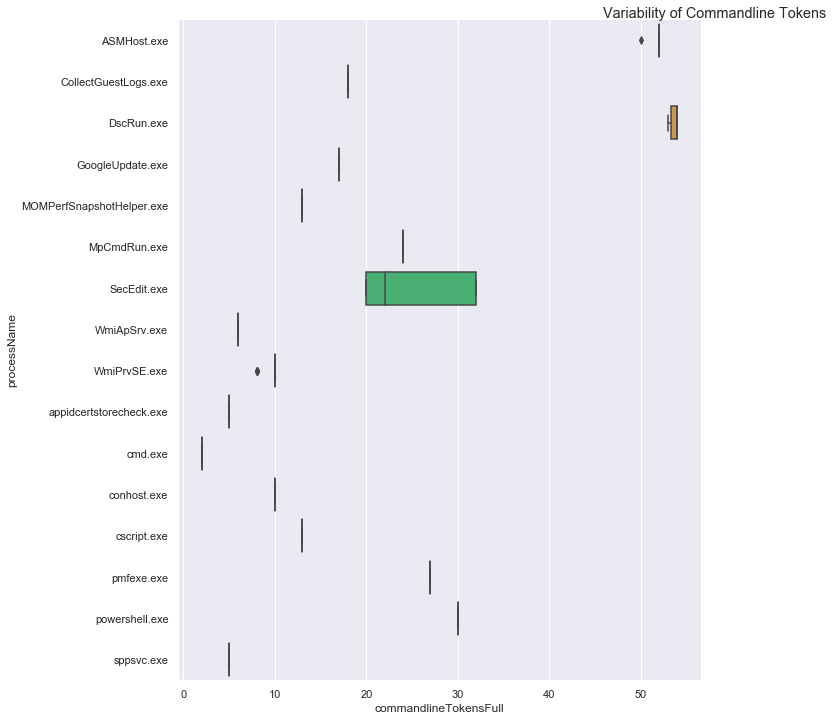

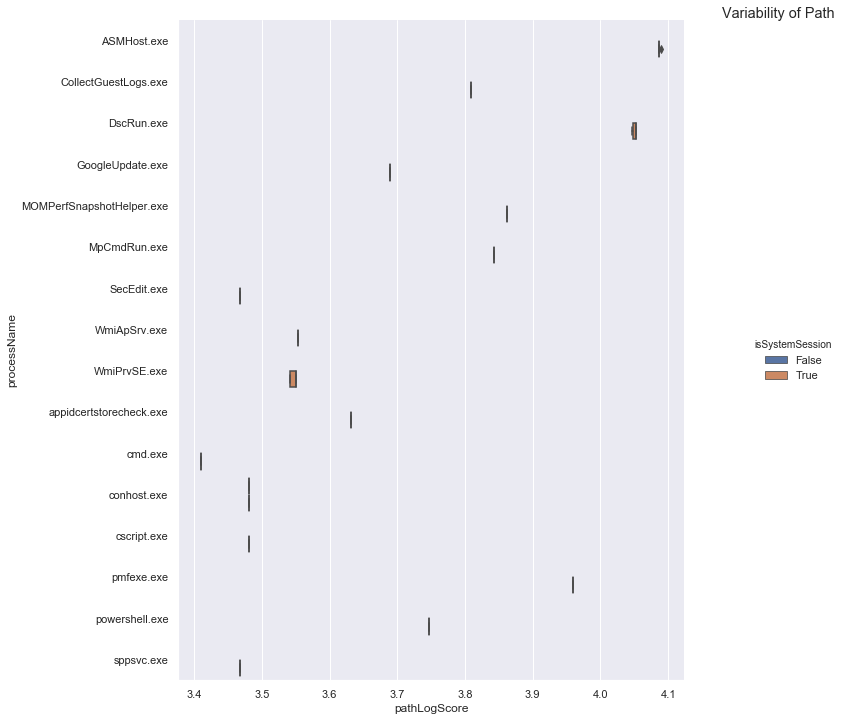

In [41]:
# Looking at the variability of commandlines and process image paths
import seaborn as sns
sns.set(style="darkgrid")

if processes_on_host is not None and not processes_on_host.empty:
    proc_plot = sns.catplot(y="processName", x="commandlineTokensFull", 
                            data=feature_procs.sort_values('processName'),
                            kind='box', height=10)
    proc_plot.fig.suptitle('Variability of Commandline Tokens', x=1, y=1)

    proc_plot = sns.catplot(y="processName", x="pathLogScore", 
                            data=feature_procs.sort_values('processName'),
                            kind='box', height=10, hue='isSystemSession')
    proc_plot.fig.suptitle('Variability of Path', x=1, y=1);

In [42]:
if 'clus_events' in locals() and not clus_events.empty:
    resp = input('View the clustered data? y/n')
    if resp == 'y':
        display(clus_events.sort_values('TimeGenerated')[['TimeGenerated', 'LastEventTime',
                                                          'NewProcessName', 'CommandLine', 
                                                          'ClusterSize', 'commandlineTokensFull',
                                                          'pathScore', 'isSystemSession']])

View the clustered data? y/ny


,TimeGenerated,LastEventTime,NewProcessName,CommandLine,ClusterSize,commandlineTokensFull,pathScore,isSystemSession
43,2019-12-30 14:56:48.803,2019-12-30 15:57:08.833,C:\ProgramData\Microsoft\Windows Defender\platform\4.18.1911.3-0\MpCmdRun.exe,"""C:\ProgramData\Microsoft\Windows Defender\platform\4.18.1911.3-0\MpCmdRun.exe"" GetDeviceTicket ...",6,24,6963,True
4,2019-12-30 14:56:52.010,2019-12-30 16:05:52.000,C:\Windows\System32\cscript.exe,"""C:\Windows\system32\cscript.exe"" /nologo ""MonitorKnowledgeDiscovery.vbs""",70,13,3022,True
5,2019-12-30 14:56:52.013,2019-12-30 16:05:52.003,C:\Windows\System32\conhost.exe,\??\C:\Windows\system32\conhost.exe 0xffffffff -ForceV1,95,10,3028,True
2,2019-12-30 14:57:47.907,2019-12-30 16:01:45.307,C:\Windows\System32\wbem\WmiPrvSE.exe,C:\Windows\system32\wbem\wmiprvse.exe -secured -Embedding,22,10,3546,True
22,2019-12-30 14:58:52.000,2019-12-30 16:02:53.010,C:\Program Files\Microsoft Monitoring Agent\Agent\Health Service State\CT_930156107\NativeDSC\De...,"""C:\Program Files\Microsoft Monitoring Agent\Agent\Health Service State\CT_930156107\NativeDSC\D...",15,52,12217,True
10,2019-12-30 15:07:55.793,2019-12-30 15:58:00.803,C:\Windows\System32\SecEdit.exe,"""C:\Windows\system32\SecEdit.exe"" /export /cfg C:\Packages\Plugins\Microsoft.GuestConfiguration....",40,32,2935,True
0,2019-12-30 15:08:13.023,2019-12-30 15:57:38.223,C:\Windows\System32\SecEdit.exe,"C:\Windows\system32\secedit.exe /export /cfg ""C:\ProgramData\GuestConfig\Configuration\AzureBase...",24,20,2935,True
1,2019-12-30 15:08:13.600,2019-12-30 15:57:38.263,C:\Windows\System32\SecEdit.exe,"C:\Windows\system32\secedit.exe /export /mergedpolicy /cfg ""C:\ProgramData\GuestConfig\Configura...",24,22,2935,True
49,2019-12-30 15:09:39.227,2019-12-30 16:02:16.903,C:\Windows\System32\sppsvc.exe,C:\Windows\system32\sppsvc.exe,2,5,2933,True
33,2019-12-30 15:09:39.840,2019-12-30 16:02:16.927,C:\Windows\System32\wbem\WmiPrvSE.exe,C:\Windows\system32\wbem\wmiprvse.exe -Embedding,6,8,3546,True


In [43]:
# Look at clusters for individual process names
def view_cluster(exe_name):
    display(clus_events[['ClusterSize', 'processName', 'CommandLine', 'ClusterId']][clus_events['processName'] == exe_name])
    
display(Markdown('You can view the cluster members for individual processes'
                 'by inserting a new cell and entering:<br>'
                 '`>>> view_cluster(process_name)`<br></div>'
                 'where process_name is the unqualified process binary. E.g<br>'
                 '`>>> view_cluster(\'reg.exe\')`'))

You can view the cluster members for individual processesby inserting a new cell and entering:<br>`>>> view_cluster(process_name)`<br></div>where process_name is the unqualified process binary. E.g<br>`>>> view_cluster('reg.exe')`

### Time Line of  clustered processes data vs. original data

In [44]:
# Show timeline of events - clustered events
if 'clus_events' in locals() and not clus_events.empty:
    nbdisplay.display_timeline(data=clus_events, 
                            overlay_data=processes_on_host, 
                            alert=security_alert, 
                            title='Distinct Host Processes (bottom) and All Proceses (top)')

Loading BokehJS ...

<a></a>[Contents](#toc)
## Base64 Decode and Check for IOCs
This section looks for Indicators of Compromise (IoC) within the data sets passed to it.

The first section looks at the command line for the process related to our original alert (if any). It also looks for Base64 encoded strings within the data - this is a common way of hiding attacker intent. It attempts to decode any strings that look like Base64. Additionally, if the Base64 decode operation returns any items that look like a Base64 encoded string or file, a gzipped binary sequence, a zipped or tar archive, it will attempt to extract the contents before searching for potentially interesting items.

In [48]:
process = security_alert.primary_process
ioc_extractor = IoCExtract()

if process and process["CommandLine"]:
    # if nothing is decoded this just returns the input string unchanged
    base64_dec_str, _ = base64.unpack_items(input_string=process["CommandLine"])
    if base64_dec_str and '<decoded' in base64_dec_str:
        print('Base64 encoded items found.')
        print(base64_dec_str)
        
    # any IoCs in the string?
    iocs_found = ioc_extractor.extract(base64_dec_str)
    
    if iocs_found:
        print('\nPotential IoCs found in alert process:')
        display(iocs_found)
    else:
        print('No IoCs found in alert process:')
else:
    print('No process command line available')


No process command line available


### IoCs in the entire data set
If we have a process tree or other elements that contain command lines we also want to attempt to extract IoCs from these data sets.

In [49]:
ioc_extractor = IoCExtract()

source_processes = None
# if process tree is populated we use that preferentially
try:
    if not process_tree.empty:
        source_processes = process_tree
except (NameError, AttributeError):
    pass 

# If not, use the clustered events from the all sessions
try:
    if source_processes is None and not clus_events.empty:
        source_processes = clus_events
except (NameError, AttributeError):
    pass
    
if source_processes is not None and not source_processes.empty: 
    ioc_df = ioc_extractor.extract(data=source_processes, 
                                   columns=['CommandLine'], 
                                   os_family=security_alert.os_family,
                                   ioc_types=['ipv4', 'ipv6', 'dns', 'url',
                                              'md5_hash', 'sha1_hash', 'sha256_hash'])
    if len(ioc_df):
        display(HTML("<h3>IoC patterns found in process tree.</h3>"))
        display(ioc_df)
else:
    ioc_df = None

,IoCType,Observable,SourceIndex
0,dns,c8f7fd15-9a9f-479c-98c1-4b00110d03eb.zip,90
1,ipv4,1.22.0.0,10


### If any Base64 encoded strings, decode and search for IoCs in the results.
For simple strings the Base64 decoded output is straightforward. However it is not uncommon to see nested encodings therefore we want to try to extract and decode these nested elements as well.

In [50]:
if source_processes is not None:
    dec_df = base64.unpack_items(data=source_processes, column='CommandLine')
    
if source_processes is not None and (dec_df is not None and not dec_df.empty):
    display(HTML("<h3>Decoded base 64 command lines</h3>"))
    display(HTML("Warning - some binary patterns may be decodable as unicode strings"))
    display(dec_df[['full_decoded_string', 'original_string', 'decoded_string', 'input_bytes', 'file_hashes']])

    ioc_dec_df = ioc_extractor.extract(data=dec_df, columns=['full_decoded_string'])
    if len(ioc_dec_df):
        display(HTML("<h3>IoC patterns found in base 64 decoded data</h3>"))
        display(ioc_dec_df)
        if ioc_df is not None:
            ioc_df = ioc_df.append(ioc_dec_df ,ignore_index=True)
        else:
            ioc_df = ioc_dec_df
else:
    print("No base64 encodings found.")

No base64 encodings found.


## Threat Intelligence Lookup
Now that we have identified a number of IoCs we want to check to see if they are associated with known mallicious activity. To do this we will query three different Threat Intelligence providers to see if we get results.

We will be using:
- VirusTotal https://www.virustotal.com/.
- Alienware OTX https://otx.alienvault.com/
- IBM X-Force https://exchange.xforce.ibmcloud.com/

If you do not have an API key for any of these providers simply remove their name from the providers list in our lookup_iocs command.

In [51]:
tilookups = TILookup()
if ioc_df is not None and not ioc_df.empty:
    ti_results = tilookups.lookup_iocs(data=ioc_df, obs_col='Observable', ioc_type_col='IoCType', providers=["OTX", "VirusTotal", "XForce"])
    if not ti_results[ti_results['Severity'] > 0].empty:
        md("Positive TI Results:",styles=["bold","red","large"])
        display(ti_results[ti_results['Severity'] > 0])
    else:
        md("No postive matches found in threat intelligence",styles=["bold","green"])
else:
    md_warn("No IOCs to lookup")

Using Open PageRank. See https://www.domcop.com/openpagerank/what-is-openpagerank


,Ioc,IocType,QuerySubtype,Provider,Result,Severity,Details,RawResult,Reference,Status
1,1.22.0.0,ipv4,None,XForce,True,1,"{'score': 1, 'cats': {'Dynamic IPs': 71}, 'categoryDescriptions': {'Dynamic IPs': 'This category...","{'ip': '1.22.0.0', 'history': [{'created': '2012-03-22T07:26:00.000Z', 'reason': 'Regional Inter...",https://api.xforce.ibmcloud.com/ipr/1.22.0.0,0


## Alert command line - Occurrence on other hosts in workspace
Understanding where else a command line is being run in an environment can give us a good idea of the scope of a security incident, or help us determine whether activity is malicious or expected.

To get a sense of whether the alert process is something that is occuring on other hosts, run this section.

In [52]:
# set the origin time to the time of our alert
query_times = nbwidgets.QueryTime(units='day', before=5, max_before=20,
                            after=1, max_after=10,
                            origin_time=security_alert.origin_time)
query_times.display()

HTML(value='<h4>Set query time boundaries</h4>')

In [54]:
# This query needs a commandline parameter which isn't supplied
# by default from the the alert 
# - so extract and escape this from the process
proc_match_in_ws = None

if not security_alert.primary_process:
    md_warn('This alert has no process entity. This section is not applicable.')
elif not security_alert.primary_process.CommandLine:
    md_warn('This alert process entity has no commandline. This section is not applicable.')

elif security_alert.primary_process:
    commandline = security_alert.primary_process.CommandLine
    commandline = utility.escape_windows_path(commandline)
    commandline = commandline.replace('"',"'")
    process = security_alert.primary_process.ProcessName
    if not process:
        raise ValueError("No process name found in selected alert")
    process = utility.escape_windows_path(process)
    process = process.replace('"',"'")
    md(f"Command Line: {commandline}", styles=["bold","red"])

    if commandline.strip():
        proc_match_in_ws = qry_prov.WindowsSecurity.list_hosts_matching_commandline(start=query_times.start, end=query_times.end, process_name=process,
                                                              commandline=commandline)

    else:
        md('process has empty commandline')
# Check the results
if proc_match_in_ws is None or proc_match_in_ws.empty:
    md('No proceses with matching commandline found in on other hosts in workspace',styles=["bold","blue"])
    md(f'between:, {query_times.start}, and, {query_times.end}',styles=["bold"])
else:
    hosts = proc_match_in_ws['Computer'].drop_duplicates().shape[0]
    processes = proc_match_in_ws.shape[0]
    md('{numprocesses} proceses with matching commandline found on {numhosts} hosts in workspace'\
         .format(numprocesses=processes, numhosts=hosts))
    md('between', query_times.start, 'and', query_times.end)
    md('To examine these execute the dataframe \'{}\' in a new cell'.format('proc_match_in_ws'))
    md(proc_match_in_ws[['TimeCreatedUtc','Computer', 'NewProcessName', 'CommandLine']].head())

If at this point you wish to investigate a particular host in detail you can use the cells below or you can switch to our Host Investigation Notebooks that provide a deep dive capability for Windows and Linux hosts.

## Host Logons
This section retrieves the logon events on the host in the alert.

You may want to use the query times to search over a broader range than the default.

In [55]:
# set the origin time to the time of our alert
query_times = nbwidgets.QueryTime(units='day', origin_time=security_alert.origin_time,
                           before=1, after=0, max_before=20, max_after=1)
query_times.display()

HTML(value='<h4>Set query time boundaries</h4>')

If you wish to investigate a specific host in detail you can use the cells below or switch to our Account investigation notebook. 

## Alert Logon Account
This returns the account associated with the alert being investigated.

In [56]:
logon_id = security_alert.get_logon_id()

if logon_id:
    if logon_id in ['0x3e7', '0X3E7', '-1', -1]:
        print('Cannot retrieve single logon event for system logon id '
              '- please continue with All Host Logons below.')
    else:
        logon_event = qry_prov.WindowsSecurity.get_host_logon(provs=[query_times, security_alert], host_name=security_alert.ExtendedProperties['Compromised Host'],start=query_times.start, end= query_times.end,logon_session_id=sess_id)
        nbdisplay.display_logon_data(logon_event, security_alert)
else:
    print('No account entity in the source alert or the primary account had no logonId value set.')

### Account Logon
Account:  AatpService
Account Domain:  CONTOSO.AZURE
Logon Time:  2019-12-29 16:00:21.203000
Logon type: 3  (Network)
User Id/SID:  S-1-5-21-2839646386-741382897-445212193-1107
    SID S-1-5-21-2839646386-741382897-445212193-1107 is local machine or domain account
Session id '0x81f2cdc9'  
Subject (source) account:  -/-
Logon process:  Kerberos
Authentication:  Kerberos
Source IpAddress:  10.0.24.4
Source Host:  -
Logon status:  



### All Host Logons
Since the number of logon events may be large and, in the case of system logons, very repetitive, we use clustering to try to identity logons with unique characteristics.

In this case we use the numeric score of the account name and the logon type (i.e. interactive, service, etc.). The results of the clustered logons are shown below along with a more detailed, readable printout of the logon event information. The data here will vary depending on whether this is a Windows or Linux host.

In [57]:
from msticpy.sectools.eventcluster import dbcluster_events, add_process_features, _string_score

if security_alert.primary_host:
    host_logons = qry_prov.WindowsSecurity.list_host_logons(query_times, security_alert,host_name=security_alert.ExtendedProperties['Compromised Host'])
else:
    host_logons = None
    md("No data available - alert has no host entity.")
    
if host_logons is not None and not host_logons.empty:
    logon_features = host_logons.copy()
    logon_features['AccountNum'] = host_logons.apply(lambda x: _string_score(x.Account), axis=1)
    logon_features['LogonHour'] = host_logons.apply(lambda x: x.TimeGenerated.hour, axis=1)

    # you might need to play around with the max_cluster_distance parameter.
    # decreasing this gives more clusters.
    (clus_logons, _, _) = dbcluster_events(data=logon_features, time_column='TimeGenerated',
                                           cluster_columns=['AccountNum',
                                                            'LogonType'],
                                                             max_cluster_distance=0.0001)
    md('Number of input events:', len(host_logons))
    md('Number of clustered events:', len(clus_logons))
    md('\nDistinct host logon patterns:')
    display(clus_logons.sort_values('TimeGenerated'))
else:
    md('No logon events found for host.', styles=["bold","red"])

,TenantId,Account,EventID,TimeGenerated,SourceComputerId,Computer,SubjectUserName,SubjectDomainName,SubjectUserSid,TargetUserName,TargetDomainName,TargetUserSid,TargetLogonId,LogonProcessName,LogonType,AuthenticationPackageName,Status,IpAddress,WorkstationName,TimeCreatedUtc,AccountNum,LogonHour,Clustered,ClusterId,ClusterSize,FirstEventTime,LastEventTime
7,ab86c959-1ba3-495c-a00d-ced30d8825d3,CONTOSO.AZURE\AatpService,4624,2019-12-29 16:00:21.203,88aac109-e3f1-4f4d-9951-9d2a13d79f43,AdminPC.Contoso.Azure,-,-,S-1-0-0,AatpService,CONTOSO.AZURE,S-1-5-21-2839646386-741382897-445212193-1107,0x88df7739,Kerberos,3,Kerberos,,10.0.24.4,-,2019-12-30 13:08:37.333,2189,13,True,2,84,2019-12-29 16:00:21.203,2019-12-30 15:10:28.953
0,ab86c959-1ba3-495c-a00d-ced30d8825d3,NT AUTHORITY\SYSTEM,4624,2019-12-29 16:19:41.587,88aac109-e3f1-4f4d-9951-9d2a13d79f43,AdminPC.Contoso.Azure,AdminPC$,CONTOSO,S-1-5-18,SYSTEM,NT AUTHORITY,S-1-5-18,0x3e7,Advapi,5,Negotiate,,-,-,2019-12-30 13:41:34.967,1484,13,True,0,43,2019-12-29 16:19:41.587,2019-12-30 14:23:16.620
1,ab86c959-1ba3-495c-a00d-ced30d8825d3,CONTOSO.AZURE\ADMINPC$,4624,2019-12-29 16:22:42.807,88aac109-e3f1-4f4d-9951-9d2a13d79f43,AdminPC.Contoso.Azure,-,-,S-1-0-0,ADMINPC$,CONTOSO.AZURE,S-1-5-18,0x88ffb7f3,Kerberos,3,Kerberos,,::1,-,2019-12-30 14:03:54.207,1622,14,True,1,16,2019-12-29 16:22:42.807,2019-12-30 14:03:54.207


In [58]:
# Display logon details
if host_logons is not None:
    nbdisplay.display_logon_data(clus_logons, security_alert)

### Account Logon
Account:  SYSTEM
Account Domain:  NT AUTHORITY
Logon Time:  2019-12-29 16:19:41.587000
Logon type: 5  (Service)
User Id/SID:  S-1-5-18
    SID S-1-5-18 is LOCAL_SYSTEM
Session id '0x3e7'  System logon session

Subject (source) account:  CONTOSO/AdminPC$
Logon process:  Advapi  
Authentication:  Negotiate
Source IpAddress:  -
Source Host:  -
Logon status:  

### Account Logon
Account:  ADMINPC$
Account Domain:  CONTOSO.AZURE
Logon Time:  2019-12-29 16:22:42.807000
Logon type: 3  (Network)
User Id/SID:  S-1-5-18
    SID S-1-5-18 is LOCAL_SYSTEM
Session id '0x88ffb7f3'  
Subject (source) account:  -/-
Logon process:  Kerberos
Authentication:  Kerberos
Source IpAddress:  ::1
Source Host:  -
Logon status:  

### Account Logon
Account:  AatpService
Account Domain:  CONTOSO.AZURE
Logon Time:  2019-12-29 16:00:21.203000
Logon type: 3  (Network)
User Id/SID:  S-1-5-21-2839646386-741382897-445212193-1107
    SID S-1-5-21-2839646386-741382897-445212193-1107 is local machine or d

### Comparing All Logons with Clustered results relative to Alert time line
To understand these logons in relation to the original alert we are investigating we want to view them in a time line.

In [59]:
# Show timeline of events - all logons + clustered logons
if host_logons is not None and not host_logons.empty:
    nbdisplay.display_timeline(data=host_logons, overlay_data=clus_logons,
                             alert=security_alert, 
                             source_columns=['Account', 'LogonType'],
                             title='All Host Logons')

Loading BokehJS ...

### View Process Session and Logon Events in Timelines
This shows the timeline of the clustered logon events with the process tree obtained earlier. This allows you to get a sense of which logon was responsible for the process tree session whether any additional logons (e.g. creating a process as another user) might be associated with the alert timeline.

*Note you should use the pan and zoom tools to align the timelines since the data may be over different time ranges.*

In [60]:
display(clus_logons.head())
process_tree.head()

,TenantId,Account,EventID,TimeGenerated,SourceComputerId,Computer,SubjectUserName,SubjectDomainName,SubjectUserSid,TargetUserName,TargetDomainName,TargetUserSid,TargetLogonId,LogonProcessName,LogonType,AuthenticationPackageName,Status,IpAddress,WorkstationName,TimeCreatedUtc,AccountNum,LogonHour,Clustered,ClusterId,ClusterSize,FirstEventTime,LastEventTime
0,ab86c959-1ba3-495c-a00d-ced30d8825d3,NT AUTHORITY\SYSTEM,4624,2019-12-29 16:19:41.587,88aac109-e3f1-4f4d-9951-9d2a13d79f43,AdminPC.Contoso.Azure,AdminPC$,CONTOSO,S-1-5-18,SYSTEM,NT AUTHORITY,S-1-5-18,0x3e7,Advapi,5,Negotiate,,-,-,2019-12-30 13:41:34.967,1484,13,True,0,43,2019-12-29 16:19:41.587,2019-12-30 14:23:16.620
1,ab86c959-1ba3-495c-a00d-ced30d8825d3,CONTOSO.AZURE\ADMINPC$,4624,2019-12-29 16:22:42.807,88aac109-e3f1-4f4d-9951-9d2a13d79f43,AdminPC.Contoso.Azure,-,-,S-1-0-0,ADMINPC$,CONTOSO.AZURE,S-1-5-18,0x88ffb7f3,Kerberos,3,Kerberos,,::1,-,2019-12-30 14:03:54.207,1622,14,True,1,16,2019-12-29 16:22:42.807,2019-12-30 14:03:54.207
7,ab86c959-1ba3-495c-a00d-ced30d8825d3,CONTOSO.AZURE\AatpService,4624,2019-12-29 16:00:21.203,88aac109-e3f1-4f4d-9951-9d2a13d79f43,AdminPC.Contoso.Azure,-,-,S-1-0-0,AatpService,CONTOSO.AZURE,S-1-5-21-2839646386-741382897-445212193-1107,0x88df7739,Kerberos,3,Kerberos,,10.0.24.4,-,2019-12-30 13:08:37.333,2189,13,True,2,84,2019-12-29 16:00:21.203,2019-12-30 15:10:28.953


,TenantId,Account,EventID,TimeGenerated,Computer,SubjectUserSid,SubjectUserName,SubjectDomainName,SubjectLogonId,NewProcessId,NewProcessName,TokenElevationType,ProcessId,CommandLine,ParentProcessName,TargetLogonId,SourceComputerId,TimeCreatedUtc,NodeRole,Level,ProcessId1,NewProcessId1


In [62]:
# Show timeline of events - all events
processes = process_tree
if processes.empty:
    processes = processes_on_host
if host_logons is not None and not host_logons.empty:
    nbdisplay.display_timeline(data=clus_logons, overlay_data=processes, source_columns=['Account'],
                             alert=security_alert,
                             title='Clustered Host Logons', height=200)

Loading BokehJS ...

In [63]:
# Counts of Logon types by Account
if host_logons is not None and not host_logons.empty:
    display(host_logons[['Account', 'LogonType', 'TimeGenerated']]
            .groupby(['Account','LogonType']).count()
            .rename(columns={'TimeGenerated': 'LogonCount'}))

,,LogonCount
Account,LogonType,
CONTOSO.AZURE\ADMINPC$,3,16
CONTOSO.AZURE\AatpService,3,84
NT AUTHORITY\SYSTEM,5,43


## Failed Logons
Failed logons can provide a valuable source of data for investigation so we also want to look at failed logons during the period of our investigation.

In [64]:
if security_alert.primary_host:
    failedLogons = qry_prov.WindowsSecurity.list_host_logon_failures(query_times, security_alert, host_name=security_alert.ExtendedProperties['Compromised Host'])
    
else:
    md_warn("No data available - alert has no host entity.")
    failedLogons = None
    

if failedLogons is None or failedLogons.empty:
    md(f'No logon failures recorded for this host between {security_alert.StartTimeUtc} and {security_alert.EndTimeUtc}', styles=["bold","blue"])
else:
    md('Failed Logons observed for the host:')
    display(failedLogons)

,TenantId,Account,EventID,TimeGenerated,SourceComputerId,Computer,SubjectUserName,SubjectDomainName,SubjectUserSid,TargetUserName,TargetDomainName,TargetUserSid,TargetLogonId,LogonProcessName,LogonType,AuthenticationPackageName,Status,IpAddress,WorkstationName,TimeCreatedUtc
0,ab86c959-1ba3-495c-a00d-ced30d8825d3,\ADMINISTRATOR,4625,2019-12-29 21:12:38.273,88aac109-e3f1-4f4d-9951-9d2a13d79f43,AdminPC.Contoso.Azure,-,-,S-1-0-0,ADMINISTRATOR,,S-1-0-0,,NtLmSsp,3,NTLM,0xc000006d,31.131.251.228,-,2019-12-29 21:12:38.273
1,ab86c959-1ba3-495c-a00d-ced30d8825d3,\ROOT,4625,2019-12-29 21:12:38.277,88aac109-e3f1-4f4d-9951-9d2a13d79f43,AdminPC.Contoso.Azure,-,-,S-1-0-0,ROOT,,S-1-0-0,,NtLmSsp,3,NTLM,0xc000006d,96.226.111.134,-,2019-12-29 21:12:38.277
2,ab86c959-1ba3-495c-a00d-ced30d8825d3,\Chen,4625,2019-12-29 21:13:00.460,88aac109-e3f1-4f4d-9951-9d2a13d79f43,AdminPC.Contoso.Azure,-,-,S-1-0-0,Chen,,S-1-0-0,,NtLmSsp,3,NTLM,0xc000006d,177.93.188.247,workstation,2019-12-29 21:13:00.460
3,ab86c959-1ba3-495c-a00d-ced30d8825d3,\ADMINISTRATOR,4625,2019-12-29 21:13:05.437,88aac109-e3f1-4f4d-9951-9d2a13d79f43,AdminPC.Contoso.Azure,-,-,S-1-0-0,ADMINISTRATOR,,S-1-0-0,,NtLmSsp,3,NTLM,0xc000006d,170.84.116.44,-,2019-12-29 21:13:05.437
4,ab86c959-1ba3-495c-a00d-ced30d8825d3,\ADMINQBID,4625,2019-12-29 21:13:05.810,88aac109-e3f1-4f4d-9951-9d2a13d79f43,AdminPC.Contoso.Azure,-,-,S-1-0-0,ADMINQBID,,S-1-0-0,,NtLmSsp,3,NTLM,0xc000006d,193.188.22.143,-,2019-12-29 21:13:05.810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18229,ab86c959-1ba3-495c-a00d-ced30d8825d3,\ADMINISTRATOR,4625,2019-12-30 00:41:50.640,88aac109-e3f1-4f4d-9951-9d2a13d79f43,AdminPC.Contoso.Azure,-,-,S-1-0-0,ADMINISTRATOR,,S-1-0-0,,NtLmSsp,3,NTLM,0xc000006d,194.61.24.3,-,2019-12-30 00:41:50.640
18230,ab86c959-1ba3-495c-a00d-ced30d8825d3,\INSTALADOR,4625,2019-12-30 00:41:58.787,88aac109-e3f1-4f4d-9951-9d2a13d79f43,AdminPC.Contoso.Azure,-,-,S-1-0-0,INSTALADOR,,S-1-0-0,,NtLmSsp,3,NTLM,0xc000006d,193.188.22.143,-,2019-12-30 00:41:58.787
18231,ab86c959-1ba3-495c-a00d-ced30d8825d3,\AUTOMATIC,4625,2019-12-30 00:41:58.800,88aac109-e3f1-4f4d-9951-9d2a13d79f43,AdminPC.Contoso.Azure,-,-,S-1-0-0,AUTOMATIC,,S-1-0-0,,NtLmSsp,3,NTLM,0xc000006d,185.156.177.119,-,2019-12-30 00:41:58.800
18232,ab86c959-1ba3-495c-a00d-ced30d8825d3,\USER,4625,2019-12-30 00:42:06.197,88aac109-e3f1-4f4d-9951-9d2a13d79f43,AdminPC.Contoso.Azure,-,-,S-1-0-0,USER,,S-1-0-0,,NtLmSsp,3,NTLM,0xc000006d,113.160.13.2,-,2019-12-30 00:42:06.197


## Appendices
### Available DataFrames

In [65]:
print('List of current DataFrames in Notebook')
print('-' * 50)
current_vars = list(locals().keys())
for var_name in current_vars:
    if isinstance(locals()[var_name], pd.DataFrame) and not var_name.startswith('_'):
        print(var_name)

List of current DataFrames in Notebook
--------------------------------------------------
process_tree
alert_list
alert_counts
related_alerts
processes_on_host
feature_procs
clus_events
source_processes
ioc_df
ti_results
logon_event
host_logons
logon_features
clus_logons
processes
failedLogons


### Saving Data to CSV
To save the contents of a pandas DataFrame to an CSV
use the following syntax
```
host_logons.to_csv('host_logons.csv')
```

### Saving Data to Excel
To save the contents of a pandas DataFrame to an Excel spreadsheet
use the following syntax
```
writer = pd.ExcelWriter('myWorksheet.xlsx')
my_data_frame.to_excel(writer,'Sheet1')
writer.save()
```

## Setup Cell
If you have not run this Notebook before please run this cell before running the rest of the Notebook.

In [69]:
import sys
import warnings
from msticpy.nbtools.utility import check_and_install_missing_packages

from IPython import get_ipython
from IPython.display import display, HTML, Markdown
import ipywidgets as widgets

warnings.filterwarnings("ignore", category=DeprecationWarning)


MIN_REQ_PYTHON = (3, 6)
if sys.version_info < MIN_REQ_PYTHON:
    print("Check the Kernel->Change Kernel menu and ensure that Python 3.6")
    print("or later is selected as the active kernel.")
    sys.exit("Python %s.%s or later is required.\n" % MIN_REQ_PYTHON)

WIDGET_DEFAULTS = {
    "layout": widgets.Layout(width="95%"),
    "style": {"description_width": "initial"},
}

# Missing Package installation
required_packages = ["ipwhois","folium","dnspython"]
check_and_install_missing_packages(required_packages)

All packages are already installed


### `msticpyconfig.yaml` configuration File
You can configure primary and secondary TI providers and any required parameters in the `msticpyconfig.yaml` file. This is read from the current directory or you can set an environment variable (`MSTICPYCONFIG`) pointing to its location.

Primary providers are used by default. Secondary providers can be invoked by using the `providers` parameter to lookup_ioc or lookup_iocs. `providers` should be a list of strings identifying the provider to use. The provider ID is given by the `Provider:` setting for each of the TI providers.

For most providers you will usually need to supply an authorization (API) key and in some cases a user ID for each provider.

For LogAnalytics/Azure Sentinel providers, you will need the workspace ID and tenant ID and will need to authenticate in order to access the data (although if you have an existing authenticated connection with the same workspace/tenant, this connection will be re-used). You can use a different workspace for TI from the one you are working in.

If you need to create a config file, uncomment the lines in the following cell.

**Warning** - this will overwrite a file of the same name in the current directory

Delete any provider entries that you do not want to use and add the missing parameters for your providers.

In [ ]:
# %%writefile msticpyconfig.yaml

# AzureSentinel:
#   #Workspaces:
#   #  Default:
#   #    WorkspaceId: "52b1ab41-869e-4138-9e40-2a4457f09bf0"
#   #    TenantId: "4cdf87a8-f0fc-40bb-9d85-68bcf4ac8e61"
#   #  Workspace2:
#   #    WorkspaceId: "c88dd3c2-d657-4eb3-b913-58d58d811a41"
#   #    TenantId: "4cdf87a8-f0fc-40bb-9d85-68bcf4ac8e61"
#   #  Workspace3:
#   #    WorkspaceId: "17e64332-19c9-472e-afd7-3629f299300c"
#   #    TenantId: "4ea41beb-4546-4fba-890b-55553ce6003a"
# QueryDefinitions:
#   # Uncomment and add paths to folders containing custom query definitions here
#   #Custom:
#   #  - /home/myuser/queries
# TIProviders:
#   OTX:
#     Args:
#       AuthKey: "your-otx-key"
#     Primary: True
#     Provider: "OTX" # Explicitly name provider to override
#   VirusTotal:
#     Args:
#       AuthKey: "your-vt-key"
#     Primary: True
#     Provider: "VirusTotal"
#   XForce:
#     # You can store items in an environment variable using this syntax
#     Args:
#       ApiID:
#         EnvironmentVar: "XFORCE_ID"
#       AuthKey:
#         EnvironmentVar: "XFORCE_KEY"
#     Primary: True
#     Provider: "XForce"
#   AzureSentinel:
#     Args:
#       # Workspace and tenant where your ThreatIndicator table is
#       # - usually the same as your default workspace
#       WorkspaceID: "52b1ab41-869e-4138-9e40-2a4457f09bf0"
#       TenantID: "4cdf87a8-f0fc-40bb-9d85-68bcf4ac8e61"
#     Primary: True
#     Provider: "AzSTI"